In [2]:
#initialization 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import numpy as np

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

#importing qiskit
import qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter, ParameterVector
from qiskit.optimization import QuadraticProgram

#import basic plot tools
from qiskit.visualization import plot_histogram, plot_state_city

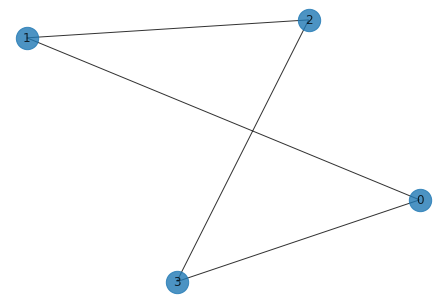

In [3]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [4]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    '''Constructs a QuadraticProblem from a given graph for a MAXCUT instance.
    Args:
        graph: UNderlying graph of the problem
    Returns: 
        QuadraticProblem
    '''
    # get weight matrix from the graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    # build QUBO matrix Q from weight matrix
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i,j] -= weight_matrix[i, j]
            qubo_vector[i] += weight_matrix[i,j]
    # define the quadraric program
    quadratic_program = QuadraticProgram('maxcut')
    for i in range(size):
        var_name = 'x_{}'.format(i)
        quadratic_program.binary_var(var_name)
    quadratic_program.maximize(quadratic=qubo_matrix, linear=qubo_vector, constant=0)
    #print(quadratic_program.export_as_lp_string())
    return quadratic_program

In [29]:
def qaoa_circuit(qubo: QuadraticProgram, gammas, betas, p: int = 1):
    '''
    Given a QUBO instance and the number of layers, construct 
    a corresponding parametrized circuit with p layers.
    Args:
        qubo: The quadratic qubo instance
        p: The number of layers in the QAOA circuit
    Returns: 
        The parametrized QAOA circuit
    '''
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()

    # Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size, size)
    # Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    # Outer loop to create eahc layer
    for layer in range(p):
        # Apply Rz rotational gates from the cost layer
        for i in range(size):
            w_i = (qubo_linearity[layer] + sum(qubo_matrix[i])) / 2
            qaoa_circuit.rz(phi=gammas[layer]*w_i, qubit=i)
        # Apply the Rzz rotational gates for entangled qubits from cost layer
        for i in range(1,size):
            for j in range(i):
                w_ij = qubo_matrix[i,j]/4
                qaoa_circuit.rzz(theta=gammas[layer]*w_ij, qubit1=i, qubit2=j)
        # Apply single qubit Rx rotations from mixer layer to all qubits
        qaoa_circuit.barrier()
        for i in range(size):
            qaoa_circuit.rx(theta=2*betas[layer], qubit=i)

    # Measure the result in computational basis
    qaoa_circuit.barrier()
    qaoa_circuit.measure(range(size), range(size))

    return qaoa_circuit

In [23]:
def compute_energy(qubo: QuadraticProgram, x: str):
    """
    Given a bitstring as a solution, returns
    the corresponding energy according to given QUBO.
    Args:
        qubo: The quadratic qubo instance
        x: Solution bitstring      
    Returns:
        e: Energy
    """
    n = len(x)
    v =  np.fromstring(x,'u1') - ord('0')
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()
    e = 0
    for i in range(n):
        for j in range(n):
            e += qubo_matrix[i][j]*v[i]*v[j]
    for i in range(n):
        e += qubo_linearity[i]*v[i]
        
    return e

In [25]:
def compute_expectation(qubo: QuadraticProgram, counts):
    """
    Computes expectation value based on measurement results
    Args:
        counts: dict
                Key as bitstring, val as count
           
        qubo: The quadratic qubo instance
    Returns:
        avg: Expectation value
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = compute_energy(qubo, bitstring)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count    

In [76]:
def get_expectation(qubo :QuadraticProgram, gammas: ParameterVector, betas: ParameterVector, p: int = 1, shots = 512):
    """
    Runs parametrized circuit
    
    Args:
        qubo: The quadratic qubo instance
        p: Number of repetitions of unitaries
        shots: The number of shots
    """    
    qc = qaoa_circuit(qubo, gammas, betas, p)
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    counts = execute(qc, backend=backend).result().get_counts(qc)
    qc.draw()
    return compute_expectation(qubo, counts)

In [90]:
qubo = quadratic_program_from_graph(G)

gammas = [np.random.random()]
betas = [np.random.random()]

x = np.linspace(3.8,4.2,20)
y = np.linspace(2.5,3.5,20)
z = np.zeros((20,20))

for i in range(20):
    for j in range(20):
        gammas, betas = [x[i]], [y[j]]
        z[i,j] = get_expectation(qubo, gammas, betas)


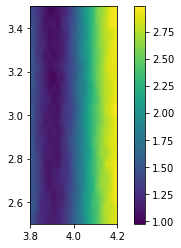

In [91]:

plt.imshow(z, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)), interpolation='bilinear')
plt.colorbar()

In [101]:
def wrapper(x):
    return (-1)*get_expectation(qubo, [x[0]],[ y[0]])

In [102]:
from scipy.optimize import minimize
    
res = minimize(wrapper, [1.0, 1.0], method='SLSQP')
res


     fun: -1.603515625
     jac: array([ 1048576., -3407872.])
 message: 'Optimization terminated successfully'
    nfev: 140
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([316.00775638, 743.15030643])

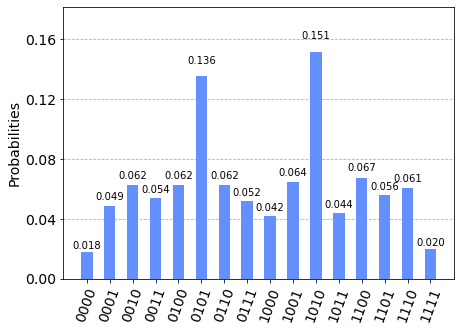

In [106]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
backend.shots = 512

qc_res = qaoa_circuit(qubo, [res.x[0]], [res.x[1]])

counts = execute(qc_res, backend=backend).result().get_counts()

plot_histogram(counts)